In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate
from weidmd import WeiDMD
import itertools
import warnings
warnings.filterwarnings("ignore")

In [2]:
## This part is written for obtaining K(t,t-tau) from the calculation results.

size_x = 100 # t
size_y = 10000 # t-tau
# v_0 = 0.001
# ampl = 0.8
freq = 4 # Frequency 
dt = 0.01 # time interval
T = int(100*1/freq) # Period T = 1/freq 
N = int(size_y/T + 1) # Number of periods that need shifting
# lambda_ = 3

# AMPL = list(np.arange(0,10,0.2))
# for i in range(len(AMPL)):
#     AMPL[i] = round(AMPL[i],2)
AMPL = [2]

# Amplitude, coincides with data

# EE1 = np.arange(-6,4,0.2)
# EE2 = np.arange(-2.1,2.1,0.2)
# EE0 = list(np.append(EE1,EE2))
# for i in range(len(EE0)):
#     EE0[i] = round(EE0[i],3)

# EE = sorted(EE0)

EE = [1.5]

# EE = list(np.arange(-6,4,0.2))
# for i in range(len(EE)):
#     EE[i] = round(EE[i],3) # Energy of site

V_0 = [0.2] # Coupling strength

LAMDBO = [0.2]

len_E = len(EE) 
len_p = len(LAMDBO) # Length of AMPL

rate = np.zeros((len_E)) # rate constant 


data1 = np.zeros((len_E,size_x,size_y))
data2 = np.zeros((len_E,size_x,size_y))
Kernel1 = np.zeros((len_E,size_x,size_y),dtype=float)
Kernel2 = np.zeros((len_E,size_x,size_y),dtype=float)

i_r = 0

for v_0,ampl,e_0,lamd in itertools.product(
    V_0,
    AMPL,
    EE,
    LAMDBO
):
    for ti in range(size_x):
        data1[i_r,ti,:] = np.loadtxt(r'./image/3-5-2022/prop-rho-eq1.dat_1_0_{}_{}_{}_{}_{}'.format(v_0, ampl, e_0, lamd, ti))
        # data2_1[i_r,ti,:] = np.loadtxt(r'image/10-31-2021-2/prop-rho-eq1.dat_0_1_{}_{}_{}_{}_{}'.format(v_0, ampl, freq, e_0, ti))
        ## Read from data
    for i in range(size_x):
        for j in range(size_y):
            t = ((j+i)%T)
            for n_p in range(int(size_x/T)):
                Kernel1[i_r,t + n_p * T,j] = data1[i_r,i,j]
                # Kernel2_1[i_r,t + n_p * T,j] = data2_1[i_r,i,j]
        ## Obtaining K(t;t-tau)
    a = 0 
    for t in range(size_x):
        a += np.sum(Kernel1[i_r,t,:])*dt*dt
    rate[i_r] = a
    i_r = i_r+1
    ## Calculate rate 

In [3]:
w1 = np.fft.fftshift(np.fft.fftfreq(len(-Kernel1[0,5,:]), dt)*np.pi*2)
Kernel_omega_r = -Kernel1[0,:,:]
Kernel_omega_i = -Kernel1[0,:,:]
for i_w in range(size_x):
    Kernel_omega_r[i_w,:] = np.fft.fftshift(np.fft.ifft(-Kernel1[0,i_w,:])*(len(-Kernel1[0,i_w,:]))*dt)
    Kernel_omega_i[i_w,:] = np.imag(np.fft.fftshift(np.fft.ifft(-Kernel1[0,i_w,:])*(len(-Kernel1[0,i_w,:]))*dt))
T = int(100*1/freq)
N_period = int(size_x/T)
c_omega_r = np.zeros((N_period+1,len(w1)),dtype=complex)
c_omega_i = np.zeros((N_period+1,len(w1)),dtype=complex)
for i_w1 in range(len(w1)):
    y1 = np.fft.ifft(Kernel_omega_r[:25,i_w1])
    y2 = np.fft.ifft(Kernel_omega_i[:25,i_w1])
    y = y1 + 1j*y2
    for i_N in range(N_period+1):
        c_omega_r[i_N,i_w1] = y1[i_N]    
        c_omega_i[i_N,i_w1] = y2[i_N]   

In [4]:
x = np.linspace(0,100,10001)
x = x[:10000]
y = np.linspace(0,4,100)
T = int(100*1/freq)
N_period = int(size_x/T)
k_omega_r = np.zeros((N_period+1,len(x)),dtype=complex)
# k_omega_i = np.zeros((N_period+1,len(x)),dtype=complex)
for i_x1 in range(len(x)):
    y1 = np.fft.ifft(-Kernel1[0,:25,i_x1])
    # y2 = np.fft.ifft(Kernel_omega_i[:25,x])
    # y = y1 + 1j*y2
    for i_N in range(N_period+1):
        k_omega_r[i_N,i_x1] = y1[i_N]    
        # c_omega_i[i_N,i_w1] = y2[i_N]   

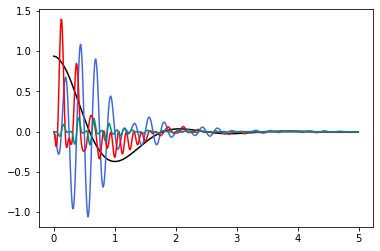

In [5]:
plt.plot(x[:500],k_omega_r[0,:500],color="black")
plt.plot(x[:500],k_omega_r[1,:500]*50,color="royalblue")
plt.plot(x[:500],k_omega_r[2,:500]*500,color="red")
plt.plot(x[:500],k_omega_r[3,:500]*5000,color="darkcyan")

In [6]:
DMD = WeiDMD(x[:500], k_omega_r[0,:500],num_snapshots=300)

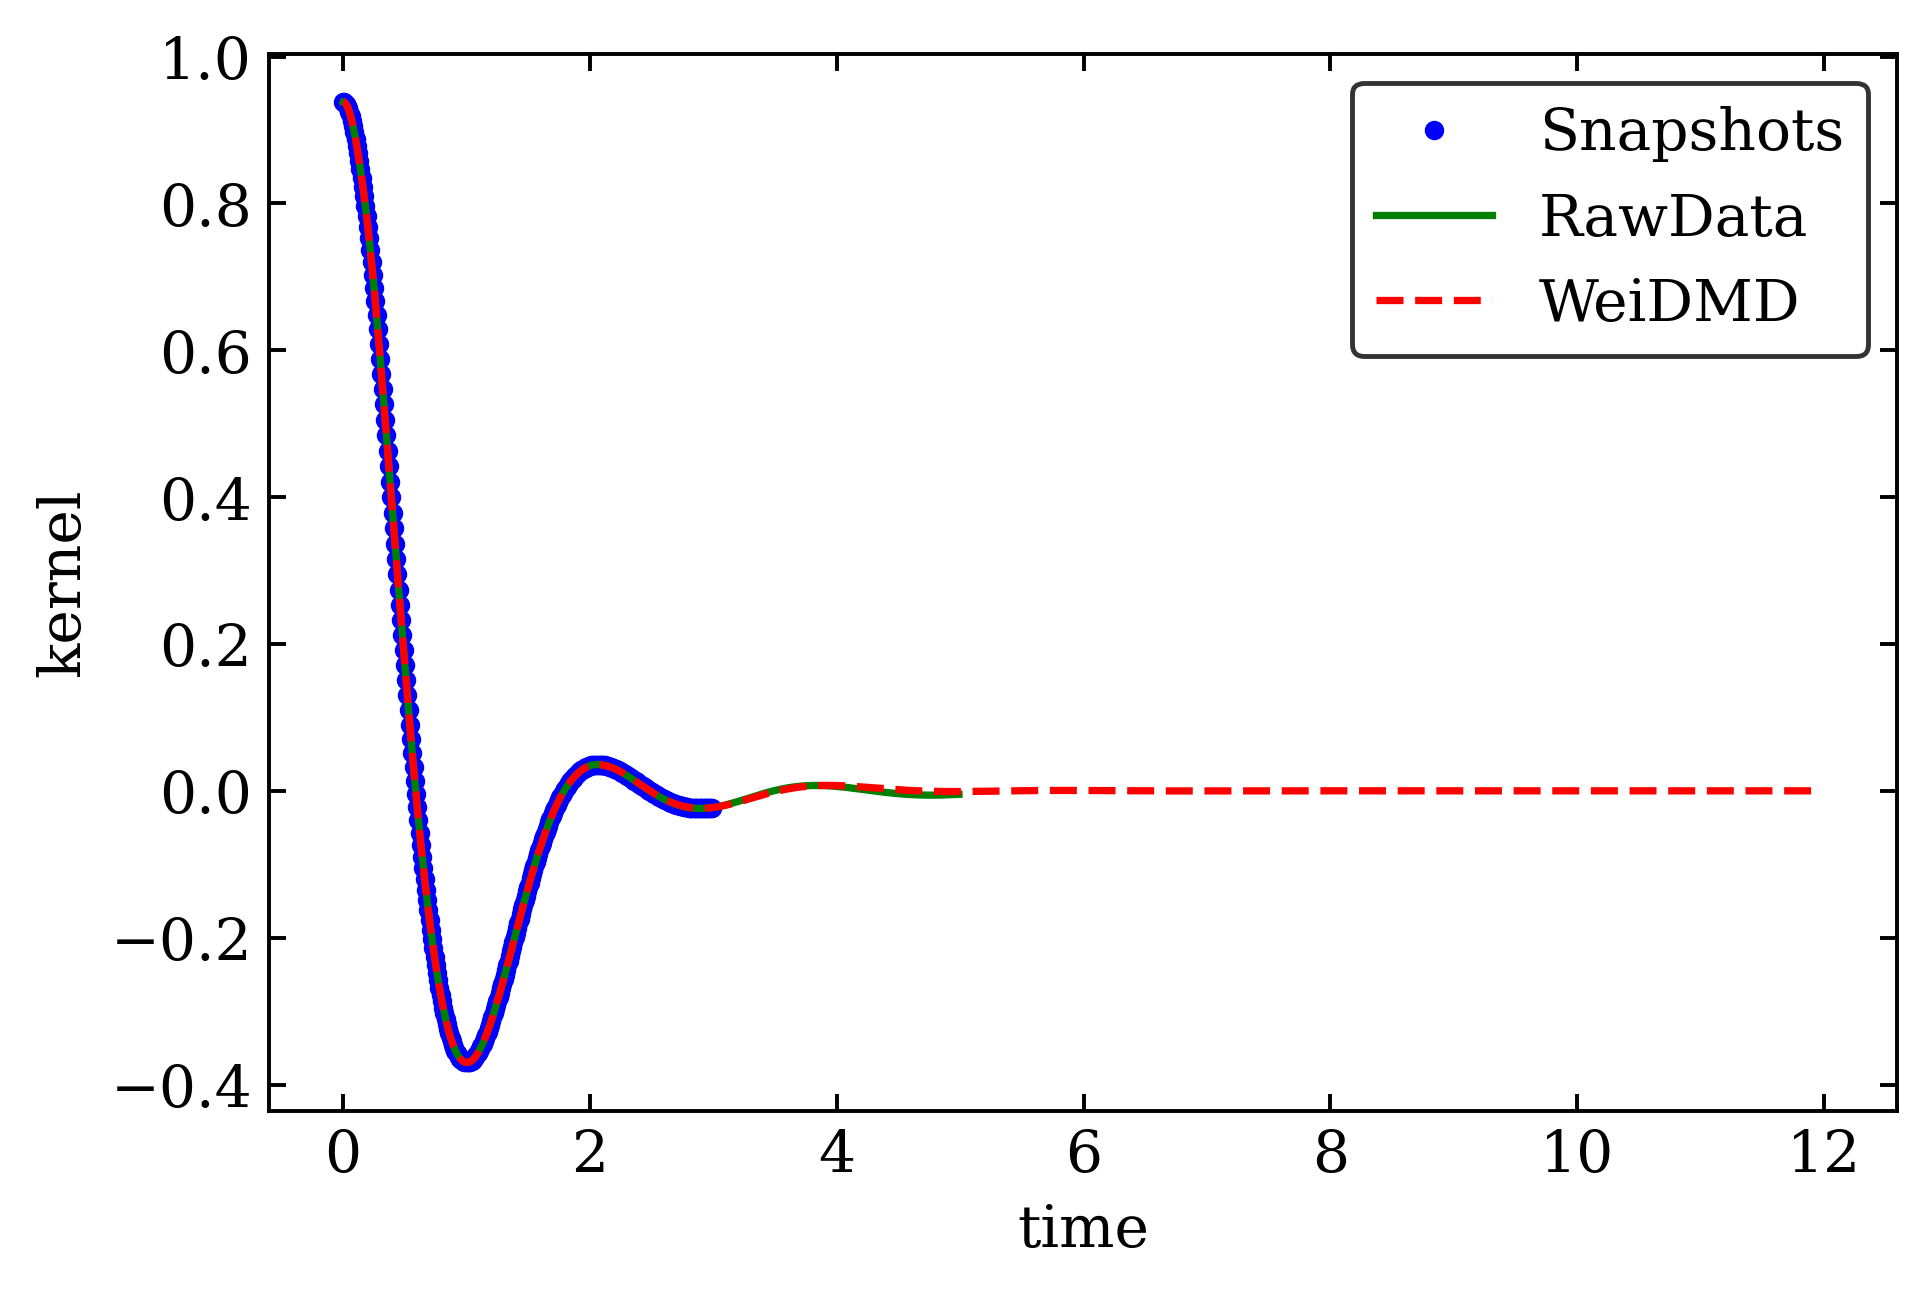

In [10]:
plt.figure(dpi=350)
DMD.fit(12,name='k_floquet')